# Plant Seedlings Classification - Tensorflow Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image
import cv2

In [2]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 1.3.0


In [3]:
IMG_SIZE = (150, 150)

## Augmentation Functions

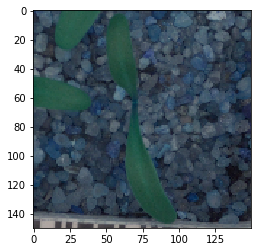

In [4]:
sample = cv2.resize(cv2.imread('../data/SeedlingData/train/Sugar beet/1347ac5ac.png'), IMG_SIZE)
plt.imshow(sample)

In [5]:
def histogram_equalize(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

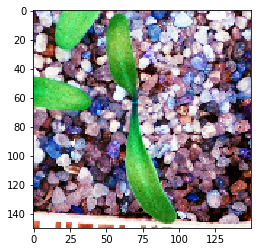

In [6]:
sample = histogram_equalize(sample)
plt.imshow(sample)

In [7]:
def random_rotate(img):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), random.randrange(360), 1)
    img_rotation = cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

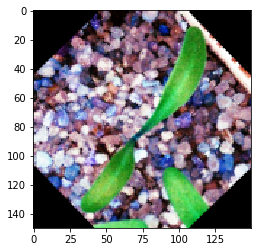

In [8]:
sample = random_rotate(sample)
plt.imshow(sample)

In [9]:
def random_zoom(img):
    x1, y1 = random.randrange(0, 20), random.randrange(0, 20)
    x2, y2 = random.randrange(130, 150), random.randrange(130, 150)
    img = img[y1:y2, x1:x2]
    img = cv2.resize(img, IMG_SIZE)
    return img

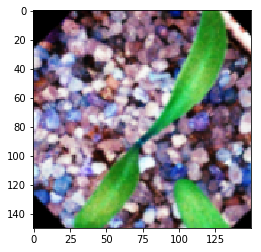

In [10]:
sample = random_zoom(sample)
plt.imshow(sample)

## Data

### - One Hot labels

In [11]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
# print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
# print(onehot_encodeded)

### - Training Data

In [12]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    _=0
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename)
        im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE)))#.ravel()
        training_data.append([im, onehot_encodeded[__]])
#         if _==0:
#             display(Image(filename, width=80, height=80))
#             print(filename)
#             print(onehot_encodeded[__])
#         _+= 1
random.shuffle(training_data)

### - Test Data

In [13]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE))).ravel()
    test_data.append([im, filename.split('/')[-1]])

### Building Model

In [14]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [15]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [16]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [17]:
def max_pool_2by2(x):
    #x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [18]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [19]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [20]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0]*IMG_SIZE[1]*3])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [21]:
#layers
x_image = tf.reshape(x, [-1, IMG_SIZE[0], IMG_SIZE[1], 3])

In [22]:
convo_1 = convolutional_layer(x_image, shape=[20,20,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [23]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[15,15,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [24]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 38*38*64])

In [25]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [26]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [27]:
y_pred = normal_full_layer(full_one_dropout, 12)

In [28]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [29]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Batch Loader

In [30]:
def load_batch(size):
    batch_x, batch_y = [],[]
    for _ in range(size):
            rand_val = random.randrange(0,len(test_data))
            batch_x.append(training_data[rand_val][0].ravel())
#             batch_x.append(random_zoom(random_rotate(training_data[rand_val][0])).ravel())
            batch_y.append(training_data[rand_val][1])
    return batch_x, batch_y    

## Runing Session

In [31]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
steps = 5000

In [33]:
plot_data = []
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            plot_data.append(temp_plot)
            print('ON STEP: {} - COST: {} '.format(i, temp_plot))
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

ON STEP: 0 - COST: 548895.625 
ON STEP: 100 - COST: 2.551657199859619 
ON STEP: 200 - COST: 2.359834671020508 
ON STEP: 300 - COST: 2.470608711242676 
ON STEP: 400 - COST: 2.542048454284668 
ON STEP: 500 - COST: 2.4488449096679688 
ON STEP: 600 - COST: 2.6948068141937256 
ON STEP: 700 - COST: 2.4613215923309326 
ON STEP: 800 - COST: 2.4568190574645996 
ON STEP: 900 - COST: 2.5020453929901123 
ON STEP: 1000 - COST: 2.5116777420043945 
ON STEP: 1100 - COST: 2.448350429534912 
ON STEP: 1200 - COST: 2.342407464981079 
ON STEP: 1300 - COST: 2.5442605018615723 
ON STEP: 1400 - COST: 2.3766138553619385 
ON STEP: 1500 - COST: 2.4613993167877197 
ON STEP: 1600 - COST: 2.484591007232666 
ON STEP: 1700 - COST: 2.521655321121216 
ON STEP: 1800 - COST: 2.348658561706543 
ON STEP: 1900 - COST: 2.3810362815856934 
ON STEP: 2000 - COST: 2.4226369857788086 
ON STEP: 2100 - COST: 2.346660614013672 
ON STEP: 2200 - COST: 2.417126417160034 
ON STEP: 2300 - COST: 2.29286789894104 
ON STEP: 2400 - COST: 2.4

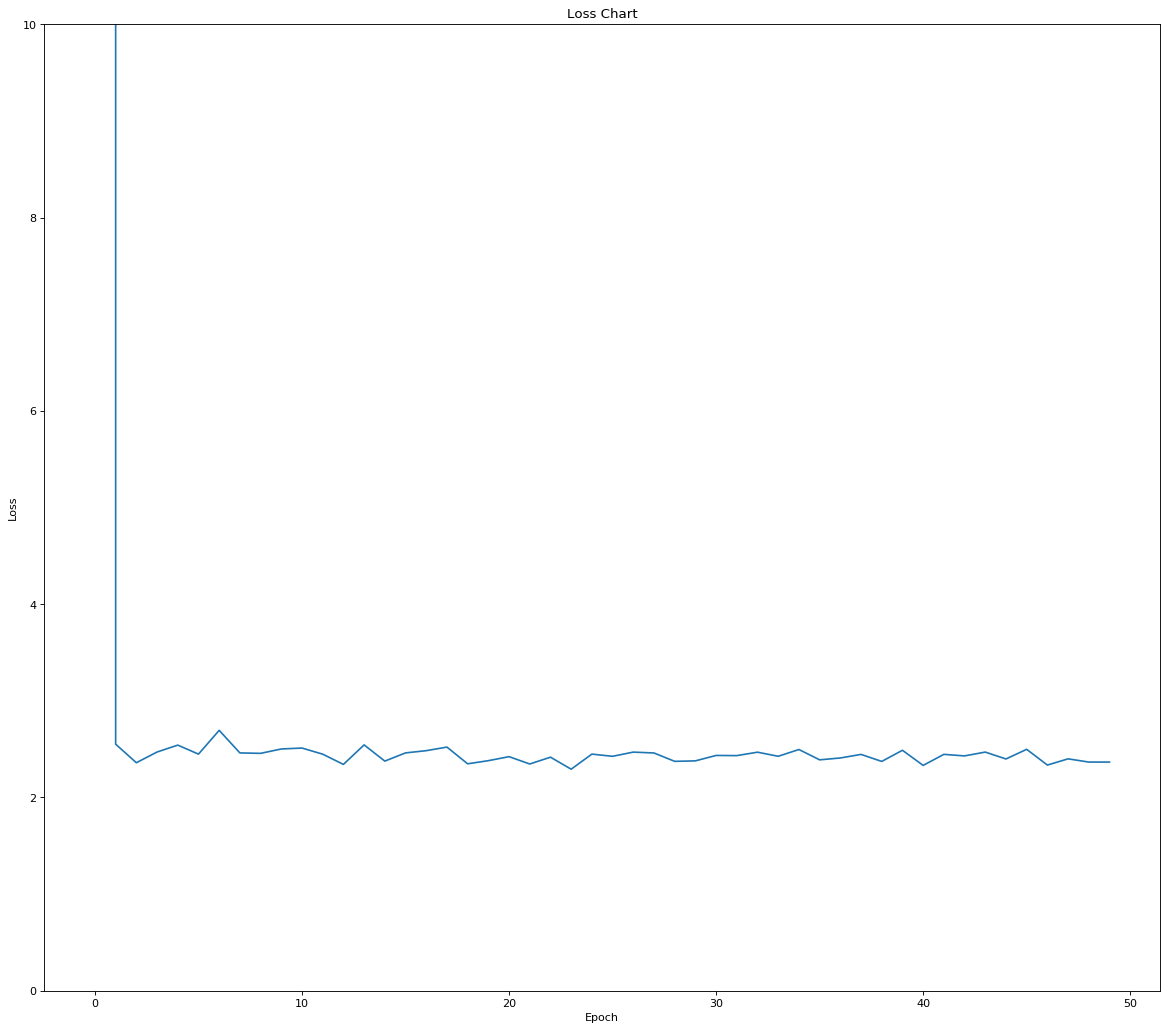

In [34]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim(0,10)
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(plot_data)

In [35]:
outs_ = []
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('seedlings-model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("Placeholder:0")
    for i in range(len(test_data)):
        feed ={x: [test_data[i][0]], hold_prob:1}

        op_to_restore = tf.nn.softmax(graph.get_tensor_by_name("add_3:0"))

        aaa = sess.run(op_to_restore, feed).ravel().tolist()
        aaa = aaa.index(max(aaa))
        print(dirs[aaa])
        outs_.append([test_data[i][1], dirs[aaa]])

INFO:tensorflow:Restoring parameters from ./seedlings-model.ckpt
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Common Chickweed


Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Small-flowered Cranesbill
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Loose

## Writing csv submition

In [36]:
import csv
with open('submition.csv', 'w') as csvfile:
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(outs_)):
        writer.writerow({'file': outs_[i][0], 'species':outs_[i][1]})
    print("csv file ready")

csv file ready
